In [54]:
import pandas as pd
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from matplotlib.lines import Line2D
from matplotlib.dates import YearLocator, DateFormatter
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

In [55]:
df = pd.read_csv('assets/csv/PEDE_PASSOS_DATASET_FIAP.csv', sep=';')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [57]:
def filter_columns(df, filters: list): # adiciono no array o padrão que existe nas colunas e que não quero que tenha na saída final
    selected_columns = [True] * len(df.columns)  # Inicializa todas as colunas como True
    for index, column in enumerate(df.columns):
        if any(filter in column for filter in filters): selected_columns[index] = False
    return df[df.columns[selected_columns]]

In [58]:
def cleaning_dataset(df):
  _df = df.dropna(subset=df.columns.difference(['NOME']), how='all') # executa o dropna para todas as colunas sem visualizar a coluna NOME
  _df = _df[~_df.isna().all(axis=1)] # remove linhas com apenas NaN, se tiver algum dado na linha não remove
  return _df

In [59]:
# Função para extrair o valor numérico da string
def extrair_numero(valor):
    # Encontrar todos os números na string e retornar o primeiro encontrado
    numeros = re.findall(r'\d+', str(valor))
    if numeros:
        return int(numeros[0])
    else:
        return None

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [61]:
df = df.round(2)

In [62]:
print(df.dtypes)

INSTITUICAO_ENSINO_ALUNO_2020     object
NOME                              object
IDADE_ALUNO_2020                  object
ANOS_PM_2020                      object
FASE_TURMA_2020                   object
                                  ...   
INDICADO_BOLSA_2022               object
PONTO_VIRADA_2022                 object
IPV_2022                         float64
IAN_2022                         float64
NIVEL_IDEAL_2022                  object
Length: 69, dtype: object


In [63]:
# Filtrando 2020
df_2020 = filter_columns(df, ['2021', '2022'])

# Filtrando 2021
df_2021 = filter_columns(df, ['2020', '2022'])

# Filtrando 2022
df_2022 = filter_columns(df, ['2020', '2021'])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  728 non-null    object 
 1   NOME                           1349 non-null   object 
 2   IDADE_ALUNO_2020               728 non-null    object 
 3   ANOS_PM_2020                   728 non-null    object 
 4   FASE_TURMA_2020                728 non-null    object 
 5   PONTO_VIRADA_2020              702 non-null    object 
 6   INDE_2020                      728 non-null    object 
 7   INDE_CONCEITO_2020             728 non-null    object 
 8   PEDRA_2020                     728 non-null    object 
 9   DESTAQUE_IEG_2020              728 non-null    object 
 10  DESTAQUE_IDA_2020              728 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       728 non-null    o

In [65]:
# Analisando a idade dos alunos

df_idade = df
df_idade['IDADE_ALUNO_2020'] = pd.to_numeric(df['IDADE_ALUNO_2020'], errors='coerce')
df_idade['IDADE_ALUNO_2020'] = df['IDADE_ALUNO_2020'].fillna(0).astype(int)
df_idade = df.dropna(subset=['IDADE_ALUNO_2020'])
df_idade = df[df['IDADE_ALUNO_2020'] > 0]

In [66]:
df_idade.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 1347
Data columns (total 69 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   INSTITUICAO_ENSINO_ALUNO_2020  727 non-null    object 
 1   NOME                           727 non-null    object 
 2   IDADE_ALUNO_2020               727 non-null    int64  
 3   ANOS_PM_2020                   727 non-null    object 
 4   FASE_TURMA_2020                727 non-null    object 
 5   PONTO_VIRADA_2020              701 non-null    object 
 6   INDE_2020                      727 non-null    object 
 7   INDE_CONCEITO_2020             727 non-null    object 
 8   PEDRA_2020                     727 non-null    object 
 9   DESTAQUE_IEG_2020              727 non-null    object 
 10  DESTAQUE_IDA_2020              727 non-null    object 
 11  DESTAQUE_IPV_2020              703 non-null    object 
 12  IAA_2020                       727 non-null    object 

In [67]:
# Desvendando os dados sobre a idade dos alunos

idade_media = df_idade['IDADE_ALUNO_2020'].mean()
idade_mediana = df_idade['IDADE_ALUNO_2020'].median()
idade_variancia = df_idade['IDADE_ALUNO_2020'].var()
idade_desvio_padrao = df_idade['IDADE_ALUNO_2020'].std()
idade_moda = df_idade['IDADE_ALUNO_2020'].mode()[0]

print(f"Média: {idade_media}")
print(f"Mediana: {idade_mediana}")
print(f"Desvio Padrão: {idade_desvio_padrao}")
print(f"Variância: {idade_variancia}")
print(f"Moda: {idade_moda}")

Média: 12.408528198074277
Mediana: 12.0
Desvio Padrão: 2.829806699677048
Variância: 8.007805957537107
Moda: 10


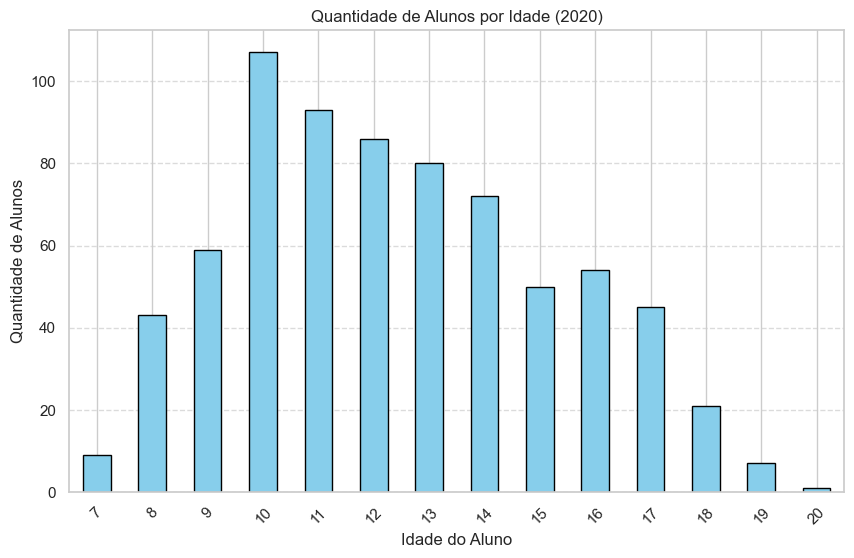

In [68]:
idade_counts = df_idade['IDADE_ALUNO_2020'].value_counts().sort_index()

# Distribuição de idade dos alunos

plt.figure(figsize=(10, 6))
idade_counts.plot(kind='bar', color='skyblue', edgecolor = 'black')
plt.xlabel('Idade do Aluno')
plt.ylabel('Quantidade de Alunos')
plt.title('Quantidade de Alunos por Idade (2020)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

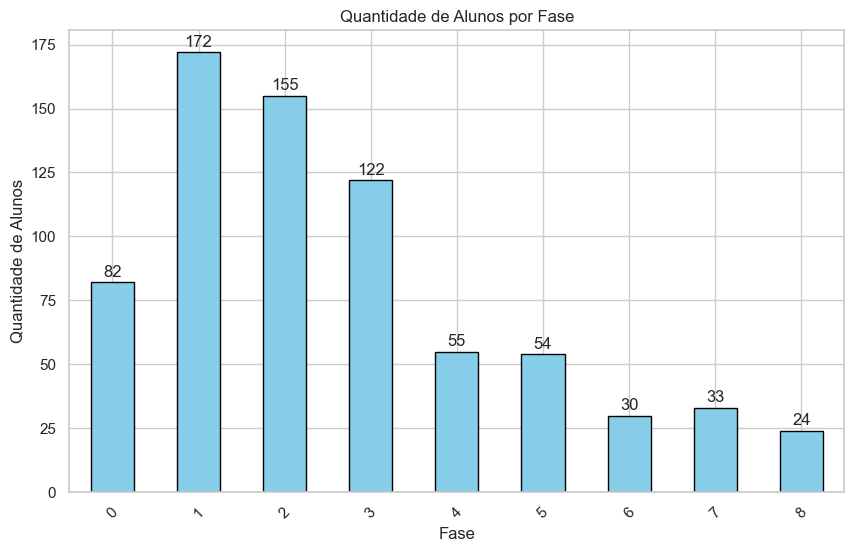

In [69]:
df_fase = df.dropna(subset=['FASE_TURMA_2020'])

# Função para extrair apenas o número da fase (ignora a letra)
df_fase['Fase_Numero'] = df_fase['FASE_TURMA_2020'].str.extract(r'(\d+)')

# Remover os valores onde a fase é '207'
df_fase = df_fase[df_fase['Fase_Numero'] != '207']

# Contar a quantidade de alunos por fase (apenas pelo número)
contagem_fases = df_fase['Fase_Numero'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = contagem_fases.plot(kind='bar', color='skyblue', edgecolor = 'black')

# Adicionar títulos e rótulos
plt.title('Quantidade de Alunos por Fase')
plt.xlabel('Fase')
plt.ylabel('Quantidade de Alunos')
plt.xticks(rotation=45)
for idx, valor in enumerate(contagem_fases):
    bars.text(idx, valor + 1, str(valor), ha='center', va='bottom')
    
plt.show()


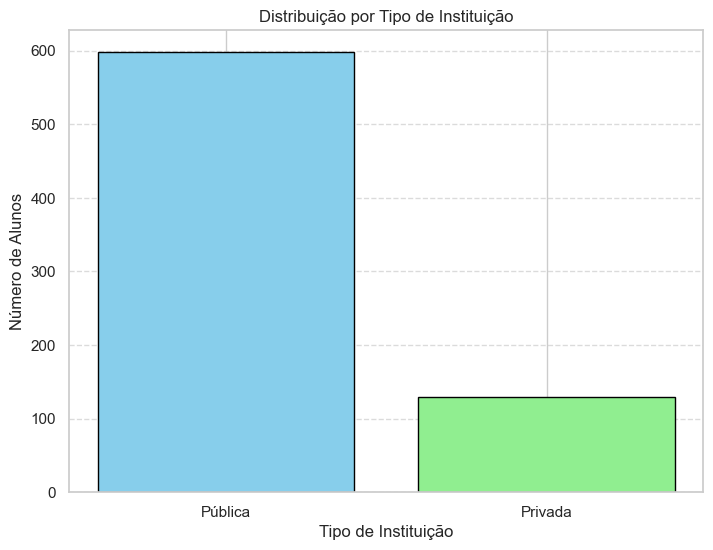

In [70]:
# Distribuição das instituições de ensino dos alunos

df_instituicao = df.dropna(subset=['INSTITUICAO_ENSINO_ALUNO_2020'])

# Contar a quantidade de alunos por tipo de instituição

df_instituicao['Tipo_Instituicao'] = df_instituicao['INSTITUICAO_ENSINO_ALUNO_2020'].apply(
    lambda x: 'Pública' if 'Pública' in str(x) else 'Privada')

# Contar a quantidade de alunos em cada tipo de instituição
contagem_tipo_instituicao = df_instituicao['Tipo_Instituicao'].value_counts()

# Filtrar apenas instituições privadas
instituicoes_privadas = df_instituicao[df_instituicao['Tipo_Instituicao'] == 'Privada']
contagem_instituicoes_privadas = instituicoes_privadas['INSTITUICAO_ENSINO_ALUNO_2020'].value_counts()

# Gráfico de distribuição por tipo de instituição

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.bar(contagem_tipo_instituicao.index, contagem_tipo_instituicao.values, color=['skyblue', 'lightgreen'], edgecolor='black')
plt.xlabel('Tipo de Instituição')
plt.ylabel('Número de Alunos')
plt.title('Distribuição por Tipo de Instituição')
plt.grid(axis='y', linestyle='--', alpha=0.7)




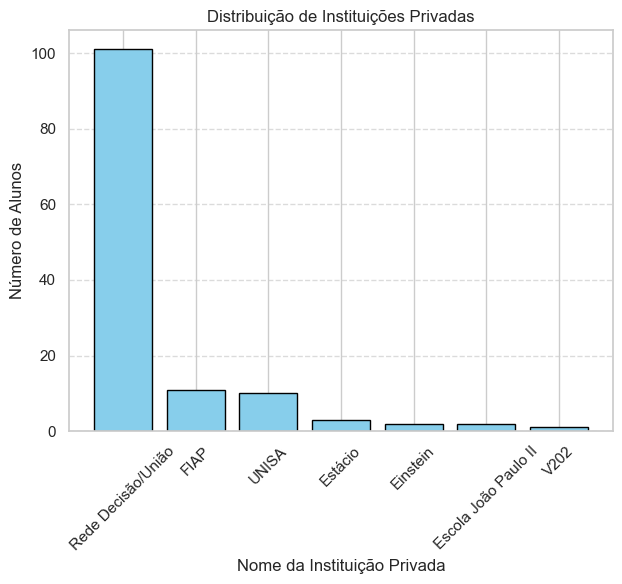

In [71]:
# Gráfico de distribuição de instituições privadas

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.bar(contagem_instituicoes_privadas.index, contagem_instituicoes_privadas.values, color='skyblue', edgecolor='black')
plt.xlabel('Nome da Instituição Privada')
plt.ylabel('Número de Alunos')
plt.title('Distribuição de Instituições Privadas')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [72]:
# Verificando e tratando os alunos que atingiram o ponto de virada.

colunas_ponto_virada = df[['PONTO_VIRADA_2020','PONTO_VIRADA_2021','PONTO_VIRADA_2022']]

ponto_atingido = ['Sim']

# Contar ocorrências para cada ano
contagem_por_ano = {col: colunas_ponto_virada[col].value_counts() for col in colunas_ponto_virada.columns}

# Exibir os resultados
for ano, contagem in contagem_por_ano.items():
    print(f"\nContagem de alunos que atingiram o {ano}:")
    print(contagem)


Contagem de alunos que atingiram o PONTO_VIRADA_2020:
PONTO_VIRADA_2020
Não      607
Sim       94
D9600      1
Name: count, dtype: int64

Contagem de alunos que atingiram o PONTO_VIRADA_2021:
PONTO_VIRADA_2021
Não       576
Sim       108
#NULO!      2
Name: count, dtype: int64

Contagem de alunos que atingiram o PONTO_VIRADA_2022:
PONTO_VIRADA_2022
Não    749
Sim    113
Name: count, dtype: int64


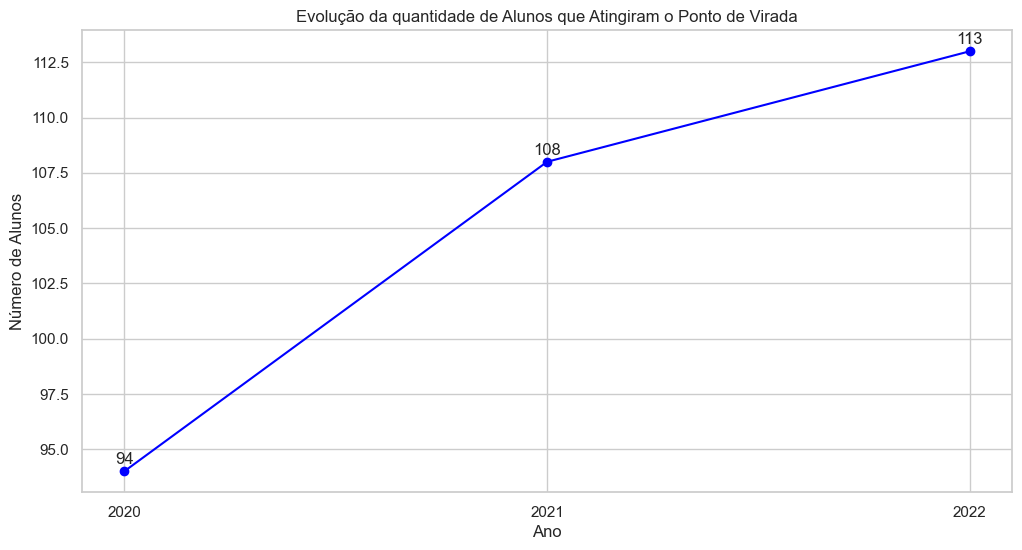

In [73]:
contagem_2020 = colunas_ponto_virada['PONTO_VIRADA_2020'].value_counts().get(ponto_atingido, 0)
contagem_2021 = colunas_ponto_virada['PONTO_VIRADA_2021'].value_counts().get(ponto_atingido, 0)
contagem_2022 = colunas_ponto_virada['PONTO_VIRADA_2022'].value_counts().get(ponto_atingido, 0)

# df com os valores de contagem
contagens = [int(contagem_2020), int(contagem_2021), int(contagem_2022)]

# Anos para o eixo X
anos = ['2020', '2021', '2022']

# Plote o gráfico
plt.figure(figsize=(12, 6))
plt.plot(anos, contagens, marker='o', linestyle='-', color='blue')
plt.xlabel('Ano')
plt.ylabel('Número de Alunos')
plt.title('Evolução da quantidade de Alunos que Atingiram o Ponto de Virada')
plt.grid(True)
plt.xticks(anos)

for idx, valor in enumerate(contagens):
    plt.annotate(str(valor), (anos[idx], valor), textcoords="offset points", xytext=(0,5), ha='center')

plt.show() 

In [74]:
# Verificando e tratando a média INDE.

df_inde = df[['NOME', 'INDE_2020', 'INDE_2021', 'INDE_2022']]
print(df_inde)

            NOME          INDE_2020 INDE_2021  INDE_2022
0        ALUNO-1           7.883752     7.319        NaN
1        ALUNO-2                NaN       NaN       7.68
2        ALUNO-3  7.856389666666666     7.021        NaN
3        ALUNO-4           5.076252       NaN       7.12
4        ALUNO-5           8.077085     7.399       7.23
...          ...                ...       ...        ...
1344  ALUNO-1345                NaN     6.606        NaN
1345  ALUNO-1346                NaN       NaN       8.14
1346  ALUNO-1347  7.158543333333334       NaN        NaN
1347  ALUNO-1348  7.842224333333333     7.422       6.75
1348  ALUNO-1349                NaN       NaN       6.40

[1349 rows x 4 columns]


In [75]:
# Analisando média geral do INDE

for col in ['INDE_2020', 'INDE_2021', 'INDE_2022']:
    df_inde[col] = pd.to_numeric(df_inde[col], errors='coerce')

colunas_numericas = df_inde.select_dtypes(include='number')

df_inde.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_inde = df_inde[['INDE_2020', 'INDE_2021', 'INDE_2022']].mean()
print(media_inde)

INDE_2020    7.296111
INDE_2021    6.888016
INDE_2022    7.028341
dtype: float64


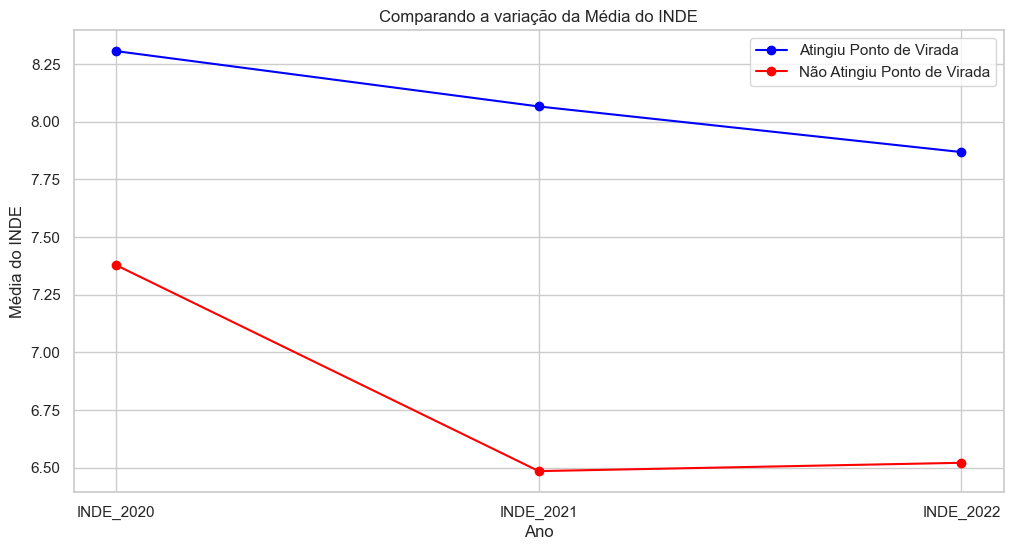

In [76]:
# Converter colunas de INDE para numérico, substituindo erros por NaN
df['INDE_2020'] = pd.to_numeric(df['INDE_2020'], errors='coerce')
df['INDE_2021'] = pd.to_numeric(df['INDE_2021'], errors='coerce')
df['INDE_2022'] = pd.to_numeric(df['INDE_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de INDE para cada grupo
media_atingiu_pv = atingiu_pv[['INDE_2020', 'INDE_2021', 'INDE_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['INDE_2020', 'INDE_2021', 'INDE_2022']].mean()

# Criar um gráfico para comparar as médias de INDE para os dois grupos
anos = ['INDE_2020', 'INDE_2021', 'INDE_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')
plt.title('Comparando a variação da Média do INDE')
plt.xlabel('Ano')
plt.ylabel('Média do INDE')
plt.grid(True)
plt.legend()
plt.show()

In [77]:
# Classificando de acordo com as pedras

analise_pedra = df[['PEDRA_2020','PEDRA_2021','PEDRA_2022']]
tipos_desejados = ['Ametista', 'Ágata', 'Quartzo', 'Topázio']

# Contar ocorrências para cada ano
contagem_por_ano = {col: analise_pedra[col].value_counts() for col in analise_pedra.columns}

# Exibir os resultados
for ano, contagem in contagem_por_ano.items():
    print(f"\nContagem de tipos de pedra para {ano}:")
    print(contagem)


Contagem de tipos de pedra para PEDRA_2020:
PEDRA_2020
Ametista    336
Ágata       171
Quartzo     128
Topázio      92
D9891/2A      1
Name: count, dtype: int64

Contagem de tipos de pedra para PEDRA_2021:
PEDRA_2021
Ametista    295
Ágata       178
Quartzo     110
Topázio     101
#NULO!        2
Name: count, dtype: int64

Contagem de tipos de pedra para PEDRA_2022:
PEDRA_2022
Ametista    348
Ágata       250
Quartzo     134
Topázio     130
Name: count, dtype: int64


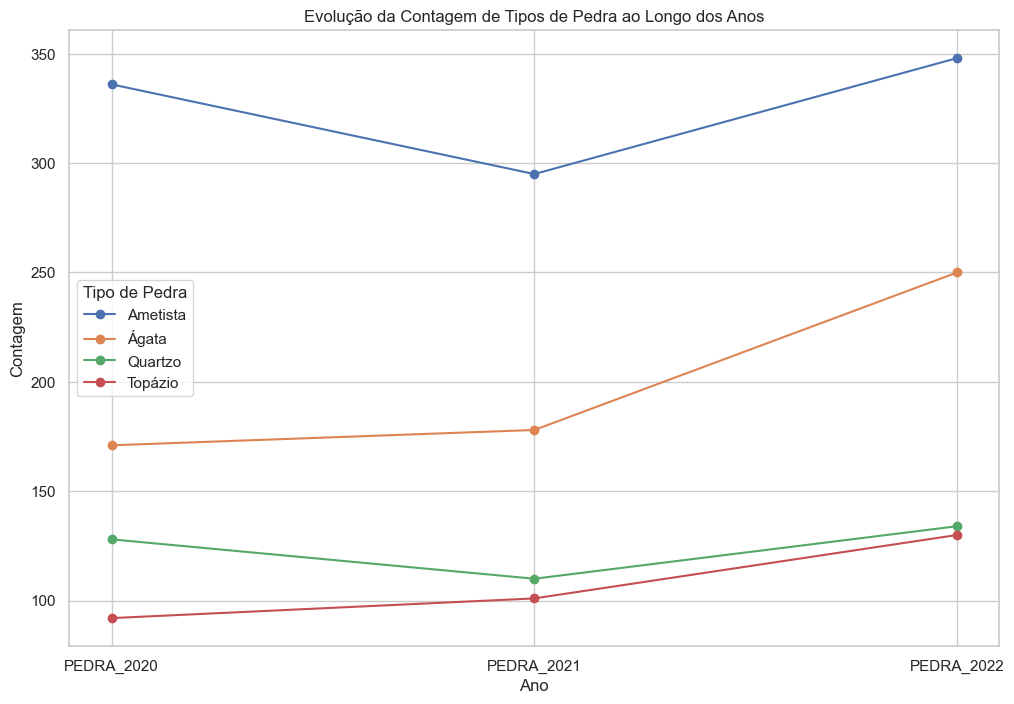

In [78]:
# Tipos de pedra que queremos analisar
tipos_desejados = ['Ametista', 'Ágata', 'Quartzo', 'Topázio']

# Filtrar o DataFrame para incluir apenas os tipos de pedra desejados
for col in analise_pedra.columns:
    analise_pedra[col] = analise_pedra[col].apply(lambda x: x if x in tipos_desejados else None)

# Contar ocorrências para cada ano
contagem_por_ano = {col: analise_pedra[col].value_counts() for col in analise_pedra.columns}

# Transformar o dicionário em DataFrame para facilitar a análise
contagem_df = pd.DataFrame(contagem_por_ano).fillna(0)

# Filtrar o DataFrame para incluir apenas as pedras desejadas
contagem_df = contagem_df.loc[tipos_desejados]

# Plotar a evolução da contagem das pedras ao longo dos anos
plt.figure(figsize=(12, 8))

# Plotar linhas para cada tipo de pedra
for pedra in contagem_df.index:
    plt.plot(contagem_df.columns, contagem_df.loc[pedra], marker='o', label=pedra)

# Adicionar detalhes ao gráfico
plt.xlabel('Ano')
plt.ylabel('Contagem')
plt.title('Evolução da Contagem de Tipos de Pedra ao Longo dos Anos')
plt.legend(title='Tipo de Pedra')
plt.grid(True)
plt.show()

In [79]:
# Verificando e tratando a média IDA.

df_ida = df[['NOME', 'IDA_2020', 'IDA_2021', 'IDA_2022']]
print(df_ida)

            NOME           IDA_2020  IDA_2021  IDA_2022
0        ALUNO-1                  7       8.8       NaN
1        ALUNO-2                NaN       NaN      8.82
2        ALUNO-3                5.5       5.6       NaN
3        ALUNO-4                  0       NaN      5.08
4        ALUNO-5                7.5       5.4      7.08
...          ...                ...       ...       ...
1344  ALUNO-1345                NaN       4.9       NaN
1345  ALUNO-1346                NaN       NaN      9.00
1346  ALUNO-1347  4.666666666666667       NaN       NaN
1347  ALUNO-1348  6.333333333333333       6.9      5.90
1348  ALUNO-1349                NaN       NaN      4.50

[1349 rows x 4 columns]


In [80]:
# Analisando média geral do IDA

for col in ['IDA_2020', 'IDA_2021', 'IDA_2022']:
    df_ida[col] = pd.to_numeric(df_ida[col], errors='coerce')

colunas_numericas = df_ida.select_dtypes(include='number')

df_ida.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ida = df_ida[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()
print(media_ida)

IDA_2020    6.322260
IDA_2021    5.425948
IDA_2022    6.070812
dtype: float64


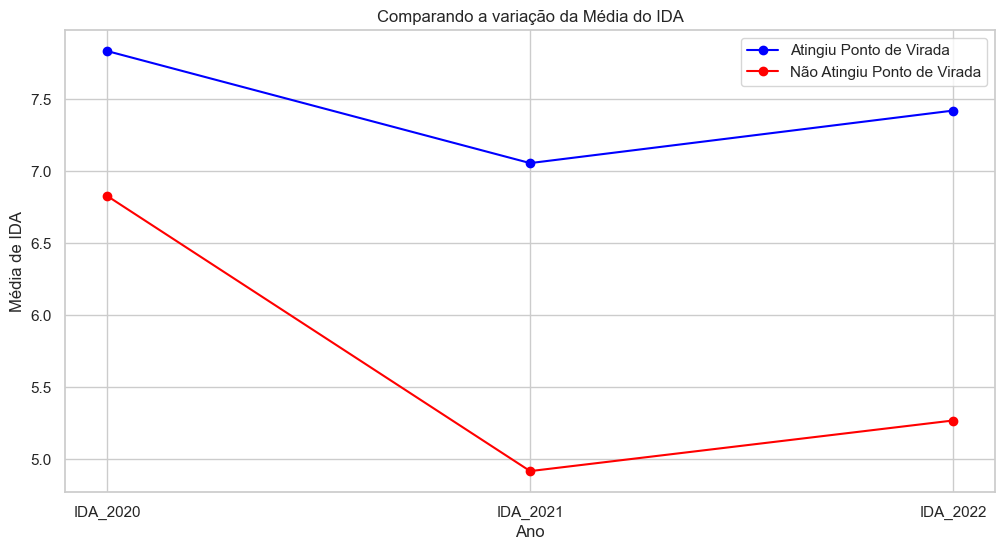

In [81]:
# Converter colunas de IDA para numérico, substituindo erros por NaN
df['IDA_2020'] = pd.to_numeric(df['IDA_2020'], errors='coerce')
df['IDA_2021'] = pd.to_numeric(df['IDA_2021'], errors='coerce')
df['IDA_2022'] = pd.to_numeric(df['IDA_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IDA para cada grupo
media_atingiu_pv = atingiu_pv[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IDA_2020', 'IDA_2021', 'IDA_2022']].mean()

# Criar um gráfico para comparar as médias de IDA para os dois grupos
anos = ['IDA_2020', 'IDA_2021', 'IDA_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IDA')
plt.xlabel('Ano')
plt.ylabel('Média de IDA')
plt.grid(True)
plt.legend()
plt.show()

In [82]:
# Verificando e tratando a média IEG.

df_ieg = df[['NOME', 'IEG_2020', 'IEG_2021', 'IEG_2022']]
print(df_ieg)

            NOME IEG_2020  IEG_2021  IEG_2022
0        ALUNO-1      8.7       6.3       NaN
1        ALUNO-2      NaN       NaN      7.58
2        ALUNO-3      8.9       6.9       NaN
3        ALUNO-4      4.1       NaN      8.07
4        ALUNO-5        8       7.5      8.56
...          ...      ...       ...       ...
1344  ALUNO-1345      NaN       6.7       NaN
1345  ALUNO-1346      NaN       NaN      9.03
1346  ALUNO-1347      8.1       NaN       NaN
1347  ALUNO-1348      7.1       8.6      9.18
1348  ALUNO-1349      NaN       NaN      7.54

[1349 rows x 4 columns]


In [83]:
# Analisando média geral do IEG

for col in ['IEG_2020', 'IEG_2021', 'IEG_2022']:
    df_ieg[col] = pd.to_numeric(df_ieg[col], errors='coerce')

colunas_numericas = df_ieg.select_dtypes(include='number')

df_ieg.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ieg = df_ieg[['IEG_2020', 'IEG_2021', 'IEG_2022']].mean()
print(media_ieg)

IEG_2020    7.681155
IEG_2021    6.822595
IEG_2022    7.880882
dtype: float64


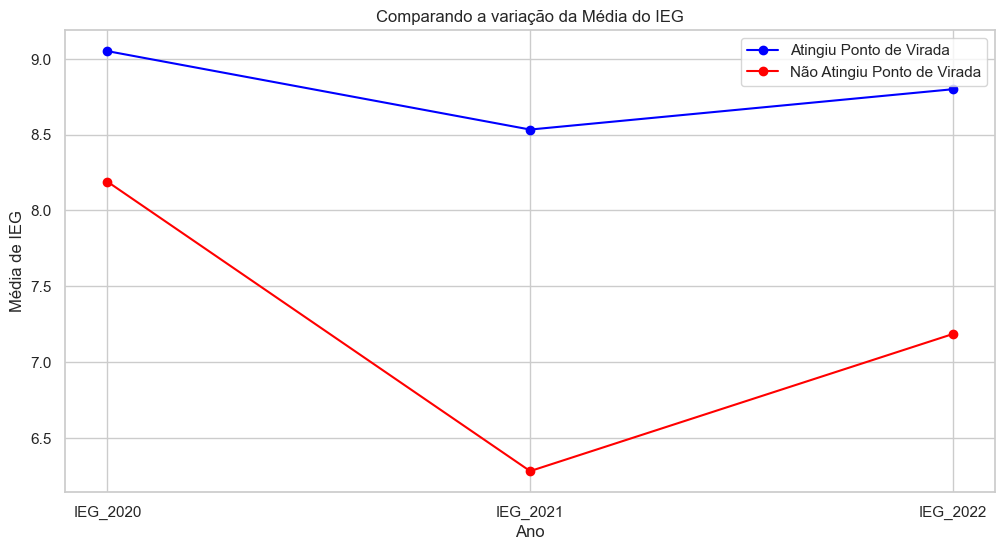

In [84]:
# Converter colunas de IEG para numérico, substituindo erros por NaN
df['IEG_2020'] = pd.to_numeric(df['IEG_2020'], errors='coerce')
df['IEG_2021'] = pd.to_numeric(df['IEG_2021'], errors='coerce')
df['IEG_2022'] = pd.to_numeric(df['IEG_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IEG para cada grupo
media_atingiu_pv = atingiu_pv[['IEG_2020', 'IEG_2021', 'IEG_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IEG_2020', 'IEG_2021', 'IEG_2022']].mean()

# Criar um gráfico para comparar as médias de IEG para os dois grupos
anos = ['IEG_2020', 'IEG_2021', 'IEG_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IEG')
plt.xlabel('Ano')
plt.ylabel('Média de IEG')
plt.grid(True)
plt.legend()
plt.show()

In [85]:
# Verificando e tratando a média IAN.

df_ian = df[['NOME', 'IAN_2020', 'IAN_2021', 'IAN_2022']]
print(df_ian)

            NOME IAN_2020  IAN_2021  IAN_2022
0        ALUNO-1       10       5.0       NaN
1        ALUNO-2      NaN       NaN       5.0
2        ALUNO-3       10      10.0       NaN
3        ALUNO-4        5       NaN       5.0
4        ALUNO-5       10      10.0       5.0
...          ...      ...       ...       ...
1344  ALUNO-1345      NaN       5.0       NaN
1345  ALUNO-1346      NaN       NaN       5.0
1346  ALUNO-1347       10       NaN       NaN
1347  ALUNO-1348       10       5.0       5.0
1348  ALUNO-1349      NaN       NaN       5.0

[1349 rows x 4 columns]


In [86]:
# Analisando média geral do IAN

for col in ['IAN_2020', 'IAN_2021', 'IAN_2022']:
    df_ian[col] = pd.to_numeric(df_ian[col], errors='coerce')

colunas_numericas = df_ian.select_dtypes(include='number')

df_ian.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ian = df_ian[['IAN_2020', 'IAN_2021', 'IAN_2022']].mean()
print(media_ian)

IAN_2020    7.431224
IAN_2021    6.902332
IAN_2022    6.421114
dtype: float64


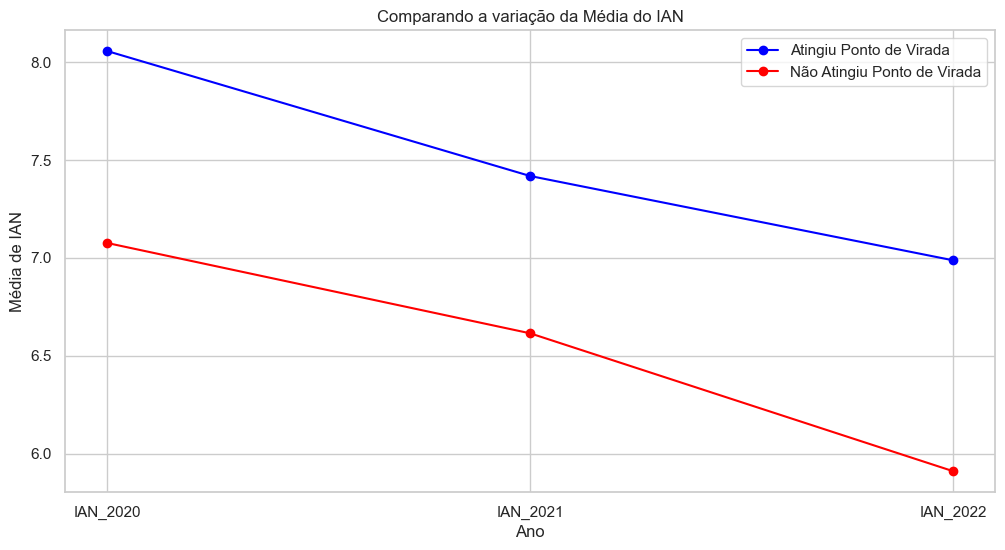

In [87]:
# Converter colunas de IAN para numérico, substituindo erros por NaN
df['IAN_2020'] = pd.to_numeric(df['IAN_2020'], errors='coerce')
df['IAN_2021'] = pd.to_numeric(df['IAN_2021'], errors='coerce')
df['IAN_2022'] = pd.to_numeric(df['IAN_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IAN para cada grupo
media_atingiu_pv = atingiu_pv[['IAN_2020', 'IAN_2021', 'IAN_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IAN_2020', 'IAN_2021', 'IAN_2022']].mean()

# Criar um gráfico para comparar as médias de IAN para os dois grupos
anos = ['IAN_2020', 'IAN_2021', 'IAN_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IAN')
plt.xlabel('Ano')
plt.ylabel('Média de IAN')
plt.grid(True)
plt.legend()
plt.show()

In [88]:
# Verificando e tratando a média IAA.

df_iaa = df[['NOME', 'IAA_2020', 'IAA_2021', 'IAA_2022']]
print(df_iaa)

            NOME           IAA_2020  IAA_2021  IAA_2022
0        ALUNO-1  8.500020000000001       7.5       NaN
1        ALUNO-2                NaN       NaN     10.00
2        ALUNO-3            7.91667       7.1       NaN
3        ALUNO-4  8.000020000000001       NaN     10.00
4        ALUNO-5            7.50002       7.4      6.42
...          ...                ...       ...       ...
1344  ALUNO-1345                NaN       9.0       NaN
1345  ALUNO-1346                NaN       NaN      9.00
1346  ALUNO-1347            9.16668       NaN       NaN
1347  ALUNO-1348            7.91667       7.5      8.33
1348  ALUNO-1349                NaN       NaN      7.92

[1349 rows x 4 columns]


In [89]:
# Analisando média geral do IAA

for col in ['IAA_2020', 'IAA_2021', 'IAA_2022']:
    df_iaa[col] = pd.to_numeric(df_iaa[col], errors='coerce')

colunas_numericas = df_iaa.select_dtypes(include='number')

df_iaa.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_iaa = df_iaa[['IAA_2020', 'IAA_2021', 'IAA_2022']].mean()
print(media_iaa)

IAA_2020    8.368882
IAA_2021    8.153499
IAA_2022    8.263248
dtype: float64


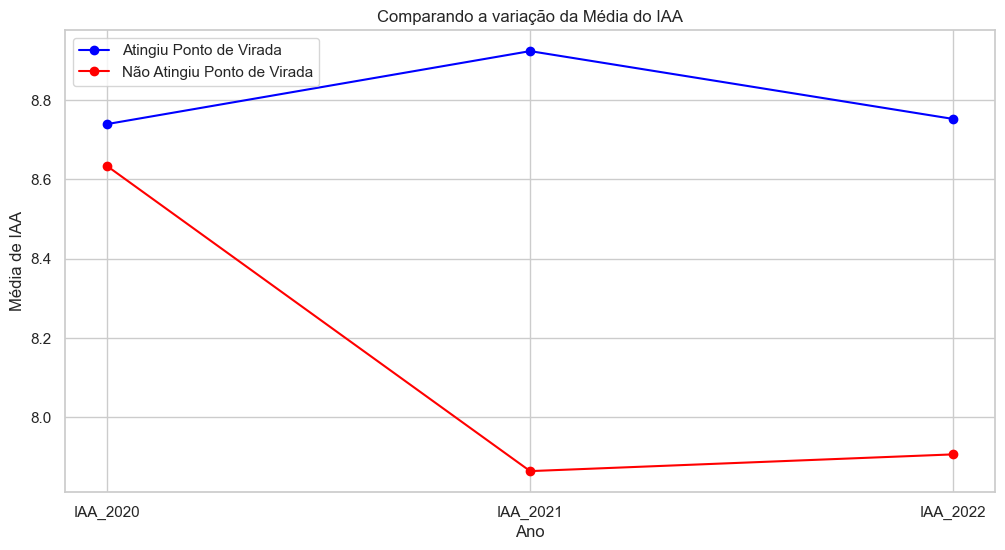

In [90]:
# Converter colunas de IAA para numérico, substituindo erros por NaN
df['IAA_2020'] = pd.to_numeric(df['IAA_2020'], errors='coerce')
df['IAA_2021'] = pd.to_numeric(df['IAA_2021'], errors='coerce')
df['IAA_2022'] = pd.to_numeric(df['IAA_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IAA para cada grupo
media_atingiu_pv = atingiu_pv[['IAA_2020', 'IAA_2021', 'IAA_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IAA_2020', 'IAA_2021', 'IAA_2022']].mean()

# Criar um gráfico para comparar as médias de IAN para os dois grupos
anos = ['IAA_2020', 'IAA_2021', 'IAA_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IAA')
plt.xlabel('Ano')
plt.ylabel('Média de IAA')
plt.grid(True)
plt.legend()
plt.show()

In [91]:
# Verificando e tratando a média IPS.

df_ips = df[['NOME', 'IPS_2020', 'IPS_2021', 'IPS_2022']]
print(df_ips)

            NOME IPS_2020  IPS_2021  IPS_2022
0        ALUNO-1      7.5       6.9       NaN
1        ALUNO-2      NaN       NaN      7.50
2        ALUNO-3      7.5       6.3       NaN
3        ALUNO-4    6.875       NaN      7.50
4        ALUNO-5      7.5       7.5      7.50
...          ...      ...       ...       ...
1344  ALUNO-1345      NaN       7.5       NaN
1345  ALUNO-1346      NaN       NaN      7.50
1346  ALUNO-1347    6.875       NaN       NaN
1347  ALUNO-1348    6.875       6.3      5.62
1348  ALUNO-1349      NaN       NaN      7.50

[1349 rows x 4 columns]


In [92]:
# Analisando média geral do IPS

for col in ['IPS_2020', 'IPS_2021', 'IPS_2022']:
    df_ips[col] = pd.to_numeric(df_ips[col], errors='coerce')

colunas_numericas = df_ips.select_dtypes(include='number')

df_ips.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ips = df_ips[['IPS_2020', 'IPS_2021', 'IPS_2022']].mean()
print(media_ips)

IPS_2020    6.737448
IPS_2021    6.843586
IPS_2022    6.900766
dtype: float64


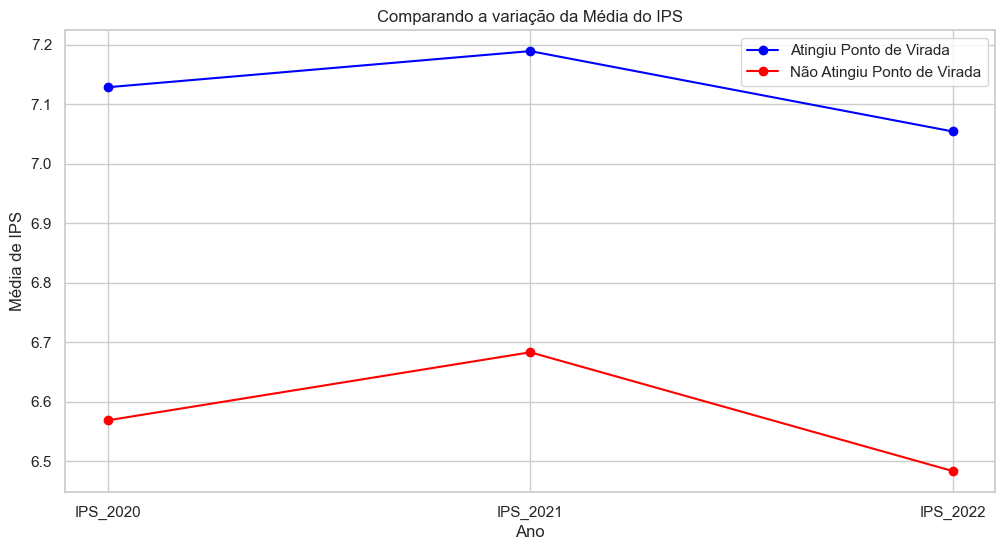

In [93]:
# Converter colunas de IPS para numérico, substituindo erros por NaN
df['IPS_2020'] = pd.to_numeric(df['IPS_2020'], errors='coerce')
df['IPS_2021'] = pd.to_numeric(df['IPS_2021'], errors='coerce')
df['IPS_2022'] = pd.to_numeric(df['IPS_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IPS para cada grupo
media_atingiu_pv = atingiu_pv[['IPS_2020', 'IPS_2021', 'IPS_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IPS_2020', 'IPS_2021', 'IPS_2022']].mean()

# Criar um gráfico para comparar as médias de IAN para os dois grupos
anos = ['IPS_2020', 'IPS_2021', 'IPS_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IPS')
plt.xlabel('Ano')
plt.ylabel('Média de IPS')
plt.grid(True)
plt.legend()
plt.show()

In [94]:
# Verificando e tratando a média IPP.

df_ipp = df[['NOME', 'IPP_2020', 'IPP_2021', 'IPP_2022']]
print(df_ipp)

            NOME           IPP_2020  IPP_2021  IPP_2022
0        ALUNO-1             5.9375       7.7       NaN
1        ALUNO-2                NaN       NaN      5.62
2        ALUNO-3              8.125       7.3       NaN
3        ALUNO-4             7.1875       NaN      6.25
4        ALUNO-5             8.4375       8.5      6.46
...          ...                ...       ...       ...
1344  ALUNO-1345                NaN       7.2       NaN
1345  ALUNO-1346                NaN       NaN      5.62
1346  ALUNO-1347            7.34375       NaN       NaN
1347  ALUNO-1348  8.541666666666666       7.5      6.72
1348  ALUNO-1349                NaN       NaN      7.50

[1349 rows x 4 columns]


In [95]:
# Analisando média geral do IPP

for col in ['IPP_2020', 'IPP_2021', 'IPP_2022']:
    df_ipp[col] = pd.to_numeric(df_ipp[col], errors='coerce')

colunas_numericas = df_ipp.select_dtypes(include='number')

df_ipp.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ipp = df_ipp[['IPP_2020', 'IPP_2021', 'IPP_2022']].mean()
print(media_ipp)

IPP_2020    7.067859
IPP_2021    7.576385
IPP_2022    6.298480
dtype: float64


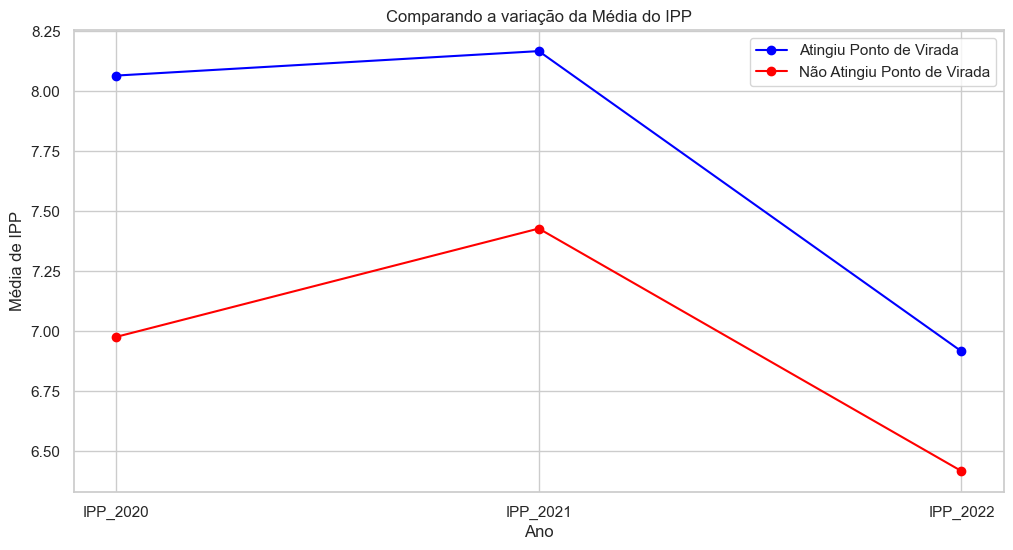

In [96]:
# Converter colunas de IPP para numérico, substituindo erros por NaN
df['IPP_2020'] = pd.to_numeric(df['IPP_2020'], errors='coerce')
df['IPP_2021'] = pd.to_numeric(df['IPP_2021'], errors='coerce')
df['IPP_2022'] = pd.to_numeric(df['IPP_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IPP para cada grupo
media_atingiu_pv = atingiu_pv[['IPP_2020', 'IPP_2021', 'IPP_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IPP_2020', 'IPP_2021', 'IPP_2022']].mean()

# Criar um gráfico para comparar as médias de IAN para os dois grupos
anos = ['IPP_2020', 'IPP_2021', 'IPP_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IPP')
plt.xlabel('Ano')
plt.ylabel('Média de IPP')
plt.grid(True)
plt.legend()
plt.show()

In [97]:
# Verificando e tratando a média IPV.

df_ipv = df[['NOME', 'IPV_2020', 'IPV_2021', 'IPV_2022']]
print(df_ipv)

            NOME           IPV_2020  IPV_2021  IPV_2022
0        ALUNO-1               7.75       8.1       NaN
1        ALUNO-2                NaN       NaN      7.92
2        ALUNO-3  8.111113333333334       7.2       NaN
3        ALUNO-4               7.75       NaN      8.06
4        ALUNO-5           8.166665       7.4      7.83
...          ...                ...       ...       ...
1344  ALUNO-1345                NaN       7.1       NaN
1345  ALUNO-1346                NaN       NaN      9.08
1346  ALUNO-1347           6.333335       NaN       NaN
1347  ALUNO-1348            9.11112       8.5      5.83
1348  ALUNO-1349                NaN       NaN      6.00

[1349 rows x 4 columns]


In [98]:
# Analisando média geral do IPV

for col in ['IPV_2020', 'IPV_2021', 'IPV_2022']:
    df_ipv[col] = pd.to_numeric(df_ipv[col], errors='coerce')

colunas_numericas = df_ipv.select_dtypes(include='number')

df_ipv.loc[:, colunas_numericas.columns] = colunas_numericas.fillna(colunas_numericas.mean())

media_ipv = df_ipv[['IPV_2020', 'IPV_2021', 'IPV_2022']].mean()
print(media_ipv)

IPV_2020    7.242243
IPV_2021    7.407580
IPV_2022    7.247981
dtype: float64


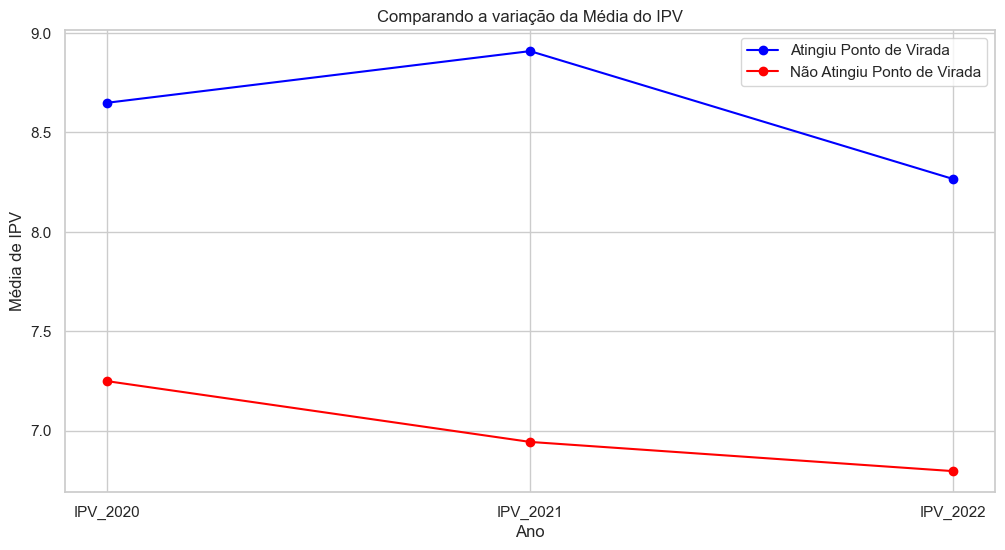

In [99]:
# Converter colunas de IPV para numérico, substituindo erros por NaN
df['IPV_2020'] = pd.to_numeric(df['IPV_2020'], errors='coerce')
df['IPV_2021'] = pd.to_numeric(df['IPV_2021'], errors='coerce')
df['IPV_2022'] = pd.to_numeric(df['IPV_2022'], errors='coerce')

# Dividir os alunos em dois grupos: atingiram (Sim) e não atingiram (Não) o ponto de virada
atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Sim') | (df['PONTO_VIRADA_2021'] == 'Sim') | (df['PONTO_VIRADA_2022'] == 'Sim')]
nao_atingiu_pv = df[(df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')]

# Calcular a média de IPV para cada grupo
media_atingiu_pv = atingiu_pv[['IPV_2020', 'IPV_2021', 'IPV_2022']].mean()
media_nao_atingiu_pv = nao_atingiu_pv[['IPV_2020', 'IPV_2021', 'IPV_2022']].mean()

# Criar um gráfico para comparar as médias de IAN para os dois grupos
anos = ['IPV_2020', 'IPV_2021', 'IPV_2022']

plt.figure(figsize=(12,6))
plt.plot(anos, media_atingiu_pv, label='Atingiu Ponto de Virada', marker='o', color = 'blue')
plt.plot(anos, media_nao_atingiu_pv, label='Não Atingiu Ponto de Virada', marker='o', color = 'red')

# Adicionar título e rótulos aos eixos
plt.title('Comparando a variação da Média do IPV')
plt.xlabel('Ano')
plt.ylabel('Média de IPV')
plt.grid(True)
plt.legend()
plt.show()

In [100]:
df.dropna(subset=['IPV_2020', 'IPV_2021', 'IPV_2022'], inplace=True)

In [101]:
# Criando o modelo de previsão para entender quais os alunos irão atingir o Ponto de virada em 2023

# 1. Preparar os dados
features = df[['IPV_2020', 'IPV_2021', 'IPV_2022']]
target = df['IPV_2022']  # Utilizando a coluna IPV_2022 como alvo para prever o próximo ano

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# 2. Treinamento do modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Prever o IPV para 2023
ipvs_previstos_2023 = model.predict(features)  # Prever baseado nas mesmas features

# 4. Calcular as notas de corte para 2020, 2021, 2022 e 2023
media_2020 = df['IPV_2020'].mean()
media_2021 = df['IPV_2021'].mean()
media_2022 = df['IPV_2022'].mean()
media_2023 = ipvs_previstos_2023.mean()

desvio_2020 = df['IPV_2020'].std()
desvio_2021 = df['IPV_2021'].std()
desvio_2022 = df['IPV_2022'].std()
desvio_2023 = ipvs_previstos_2023.std()

nota_corte_2020 = media_2020 + desvio_2020
nota_corte_2021 = media_2021 + desvio_2021
nota_corte_2022 = media_2022 + desvio_2022
nota_corte_2023 = media_2023 + desvio_2023

# 5. Determinar se os alunos atingirão o ponto de virada
resultados = []
for ipv in ipvs_previstos_2023:
    if ipv > nota_corte_2023:
        resultados.append("Sim")
    else:
        resultados.append("Não")

# Criar um DataFrame com os resultados
resultado_df = pd.DataFrame({
    'Aluno': [f'Aluno {i + 1}' for i in range(len(resultados))],
    'IPV Previsto': ipvs_previstos_2023,
    'Atingirá o ponto de virada': resultados
})

# Exibir os resultados
for idx, resultado in enumerate(resultados):
    print(f"Aluno {idx + 1}: IPV Previsto = {ipvs_previstos_2023[idx]:.2f}, Atingirá o ponto de virada: {resultado}")

# Exibir notas de corte
print(f"Nota de corte para 2020: {nota_corte_2020:.2f}")
print(f"Nota de corte para 2021: {nota_corte_2021:.2f}")
print(f"Nota de corte para 2022: {nota_corte_2022:.2f}")
print(f"Nota de corte para 2023: {nota_corte_2023:.2f}")

Aluno 1: IPV Previsto = 7.83, Atingirá o ponto de virada: Não
Aluno 2: IPV Previsto = 7.62, Atingirá o ponto de virada: Não
Aluno 3: IPV Previsto = 9.50, Atingirá o ponto de virada: Sim
Aluno 4: IPV Previsto = 7.50, Atingirá o ponto de virada: Não
Aluno 5: IPV Previsto = 7.25, Atingirá o ponto de virada: Não
Aluno 6: IPV Previsto = 6.39, Atingirá o ponto de virada: Não
Aluno 7: IPV Previsto = 7.79, Atingirá o ponto de virada: Não
Aluno 8: IPV Previsto = 7.78, Atingirá o ponto de virada: Não
Aluno 9: IPV Previsto = 6.89, Atingirá o ponto de virada: Não
Aluno 10: IPV Previsto = 6.92, Atingirá o ponto de virada: Não
Aluno 11: IPV Previsto = 7.28, Atingirá o ponto de virada: Não
Aluno 12: IPV Previsto = 7.40, Atingirá o ponto de virada: Não
Aluno 13: IPV Previsto = 9.72, Atingirá o ponto de virada: Sim
Aluno 14: IPV Previsto = 8.28, Atingirá o ponto de virada: Não
Aluno 15: IPV Previsto = 7.83, Atingirá o ponto de virada: Não
Aluno 16: IPV Previsto = 8.83, Atingirá o ponto de virada: Sim
A

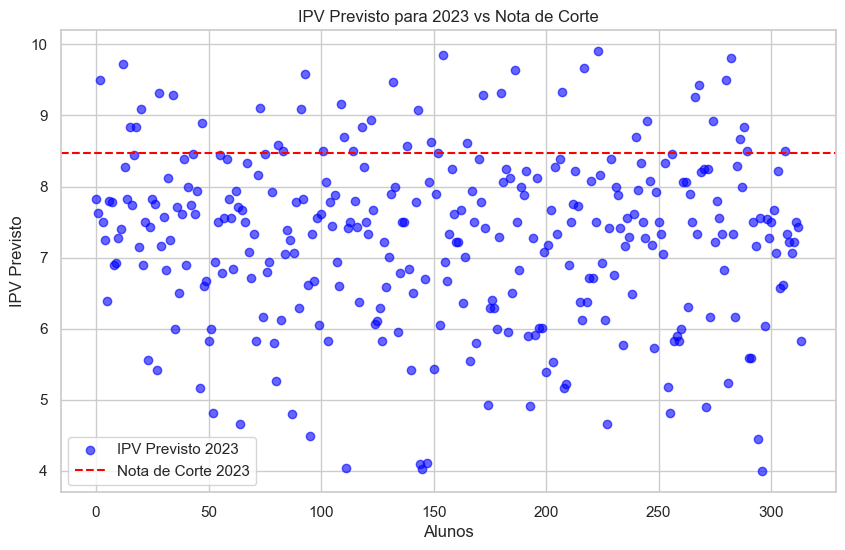

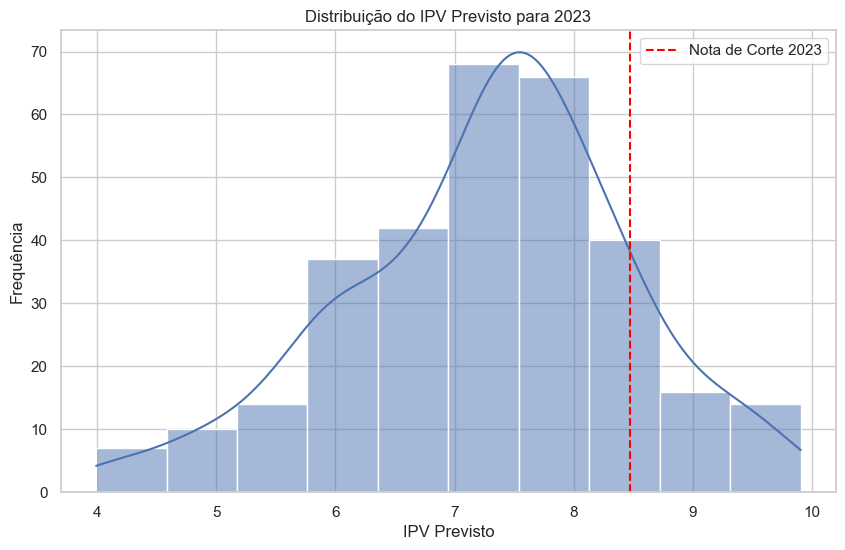

In [108]:
# Definir estilo dos gráficos
sns.set(style="whitegrid")

# 1. Gráfico de Dispersão dos IPV Previsto vs. Notas de Corte
plt.figure(figsize=(10, 6))
plt.scatter(range(len(ipvs_previstos_2023)), ipvs_previstos_2023, label='IPV Previsto 2023', color='blue', alpha=0.6)
plt.axhline(y=nota_corte_2023, color='red', linestyle='--', label='Nota de Corte 2023')
plt.title('IPV Previsto para 2023 vs Nota de Corte')
plt.xlabel('Alunos')
plt.ylabel('IPV Previsto')
plt.legend()
plt.show()

# 2. Histograma dos IPV Previsto
plt.figure(figsize=(10, 6))
sns.histplot(ipvs_previstos_2023, bins=10, kde=True)
plt.axvline(x=nota_corte_2023, color='red', linestyle='--', label='Nota de Corte 2023')
plt.title('Distribuição do IPV Previsto para 2023')
plt.xlabel('IPV Previsto')
plt.ylabel('Frequência')
plt.legend()
plt.show()

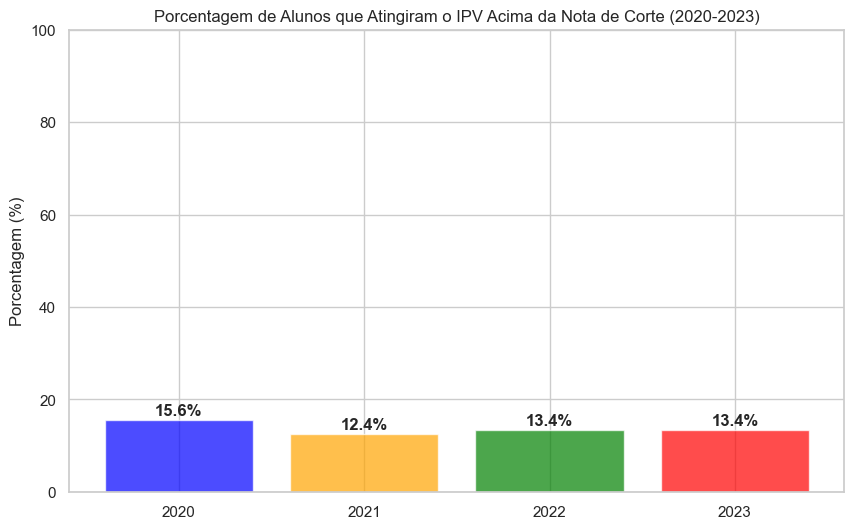

In [103]:
# Calcular porcentagens para cada ano
anos = ['2020', '2021', '2022', '2023']
notas_corte = [nota_corte_2020, nota_corte_2021, nota_corte_2022, nota_corte_2023]
ipvs = [df['IPV_2020'], df['IPV_2021'], df['IPV_2022'], ipvs_previstos_2023]

porcentagens_acima_nota_corte = []

for ipv, nota in zip(ipvs, notas_corte):
    total_alunos = len(ipv)
    alunos_acima_nota_corte = sum(i > nota for i in ipv)
    porcentagem_acima_nota_corte = (alunos_acima_nota_corte / total_alunos) * 100
    porcentagens_acima_nota_corte.append(porcentagem_acima_nota_corte)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(anos, porcentagens_acima_nota_corte, color=['blue', 'orange', 'green', 'red'], alpha=0.7)
plt.title('Porcentagem de Alunos que Atingiram o IPV Acima da Nota de Corte (2020-2023)')
plt.ylabel('Porcentagem (%)')
plt.ylim(0, 100)

# Adicionar os valores em cima das barras
for i, v in enumerate(porcentagens_acima_nota_corte):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()


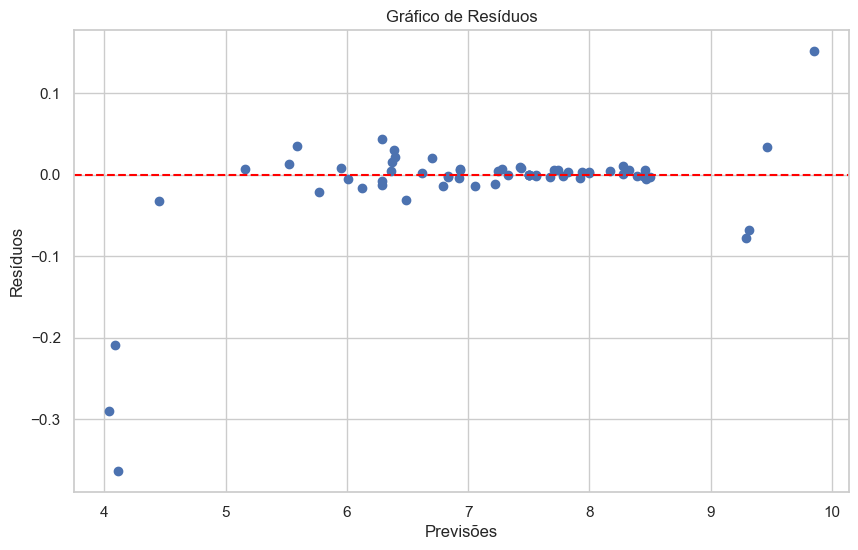

In [104]:
residuos = y_test - model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X_test), residuos)
plt.axhline(0, color='red', linestyle='--')
plt.title('Gráfico de Resíduos')
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.show()


In [105]:

mse = mean_squared_error(y_test, model.predict(X_test))
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")

rmse = mse ** 0.5
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")

mae = mean_absolute_error(y_test, model.predict(X_test))
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")

r2 = r2_score(y_test, model.predict(X_test))
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Erro Quadrático Médio (MSE): 0.00
Raiz do Erro Quadrático Médio (RMSE): 0.07
Erro Absoluto Médio (MAE): 0.03
Coeficiente de Determinação (R²): 1.00


In [106]:
# Verificar se os alunos não atingiram o ponto de virada nos anos anteriores
nunca_atenderam = (df['PONTO_VIRADA_2020'] == 'Não') & (df['PONTO_VIRADA_2021'] == 'Não') & (df['PONTO_VIRADA_2022'] == 'Não')

# Criar uma série para PONTO_VIRADA_2023 a partir das previsões
ponto_virada_2023 = ['Sim' if ipv > nota_corte_2023 else 'Não' for ipv in ipvs_previstos_2023]

# Criar um DataFrame temporário para comparação
df['PONTO_VIRADA_2023'] = ponto_virada_2023  # Adicionando a coluna ao DataFrame

# Encontrar os alunos que atingiram o ponto de virada em 2023
atingiram_2023 = df['PONTO_VIRADA_2023'] == 'Sim'

# Identificar os índices dos alunos que nunca atingiram e que atingiram em 2023
alunos_atingiram_2023 = df[nunca_atenderam & atingiram_2023]

# Exibir os resultados
if not alunos_atingiram_2023.empty:
    print("Alunos que nunca atingiram o ponto de virada em 2020, 2021 e 2022, mas atingiram em 2023:")
    print(alunos_atingiram_2023[['ID_Aluno', 'PONTO_VIRADA_2023']])  # Ajuste para as colunas que deseja mostrar
else:
    print("Nenhum aluno que nunca atingiu o ponto de virada em 2020, 2021 e 2022 atingiu em 2023.")


Nenhum aluno que nunca atingiu o ponto de virada em 2020, 2021 e 2022 atingiu em 2023.
